In [1]:
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from NN_config import Config
from HD_DataLoader import *
from NN_model import *


Get the database:

In [2]:
folder_path = os.path.join(os.getcwd(), 'HD_data') 
HD_class = HD(data_path = folder_path)
database = HD_class.generate_database()

---------------------------------------------------------
Generating database for HD's


Get the testing, training and validation set:

In [3]:
# Assuming you have a database variable containing your raw data
dataset = VairableSensorsDataset(database, mic_bool='True', vibr_bool='False', cur_bool='False', speed_bool='False', start_percentage=0.1, stop_percentage = 0.9, window_sec = 0.1, stride_sec=0.03)

# Splitting the data into train, test, and validation sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42, shuffle=True)

# Creating data loaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Start the training of the model

In [4]:
train_features, train_labels = next(iter(train_dataloader))
input_dim = train_features.shape[1]
print('The input dimension: ' + str(input_dim))
print('The amound of batches in the train loaders: ' + str(len(train_dataloader)))
      
cfg = Config()

# Initialize network
model = Classifier(input_dim)
model.train()
if cfg.enable_cuda:
    model = model.cuda()

# Initialize optimizer
# optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.lr_momentum, weight_decay=cfg.weight_decay)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

The input dimension: 4410
The amound of batches in the train loaders: 439


In [5]:
# Track losses
train_losses = []
val_losses = []
i = 0

for epoch in range(cfg.num_epochs):
    
    #Training phase
    model.train()  # Set the model in training mode
    epoch_train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.float().reshape(-1,1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

        # Print training progress
        # if (i + 1) % 10 == 0:
        #     print(f"Epoch [{epoch + 1}/{cfg.num_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
            for i, data in enumerate(val_dataloader,0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                labels = labels.float().reshape(-1,1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs >= 0.5).squeeze().long()
                total += labels.size(0)
                correct += predicted.eq(labels.squeeze()).sum().item()

    # Print training validation metrics
    val_loss /= len(val_dataloader)
    val_acc = correct / total * 100
    train_loss = epoch_train_loss / len(train_dataloader)

    print(f"Epoch [{epoch + 1}/{cfg.num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Finished training.")
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print("Saved trained model as {}.".format(save_path))

Epoch [1/10], Training Loss: 0.7245, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [2/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [3/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [4/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [5/10], Training Loss: 0.7245, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [6/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [7/10], Training Loss: 0.7245, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [8/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [9/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Epoch [10/10], Training Loss: 0.7244, Validation Loss: 0.7226, Validation Accuracy: 50.29%
Finished training.
Saved trained model as model.pth.


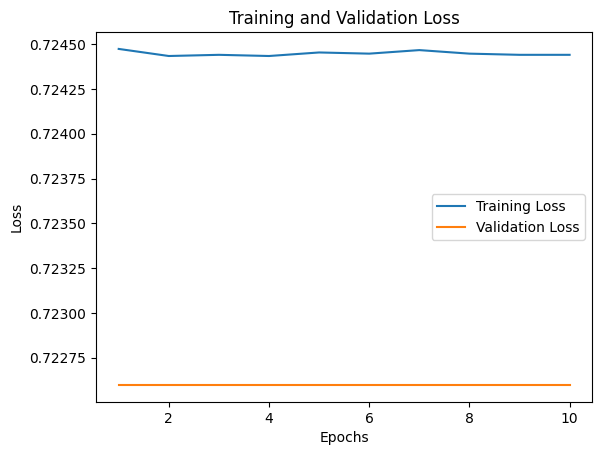

In [6]:
# Plot the losses
plt.plot(range(1, cfg.num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, cfg.num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Hugo his code using different classes in the dataloader

In [7]:
# test = SplitNormalFaulty(database)
# working, faulty = test.split_faulty_working_vib('X_vibr')
# Data_prep = DataPreprocessing(working, faulty)

# inputs, labels = Data_prep.create_data_batches()

# print("Number of inputs is {}".format(len(inputs)))


In [8]:
# x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.4, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# training_data = CustomDataset(x_train, y_train)
# test_data = CustomDataset(x_test, y_test)
# val_data = CustomDataset(x_val, y_val)

# # training_data = CustomImageDataset(x_train, y_train)
# # test_data = CustomImageDataset(x_test, y_test)

# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [9]:
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")